In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn import model_selection
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns
import geopandas as gpd
import random
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

matplotlib.rcParams['figure.figsize'] = (10, 5)
matplotlib.rcParams['font.size'] = 15
random.seed(0)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

## Data Gathering

In [2]:
# Import data
df_calendar = pd.read_csv('Data/calendar.csv', parse_dates=['date'])
df_listings = pd.read_csv('Data/listings.csv')
#df_neighbourhoods = pd.read_csv('Data/neighbourhoods.csv')

## Data Cleaning

#### Calendar Cleaning
- Remove all missing value
- Remove $ from price and adjusted_price
- Create a statistics for occupancy ratio for each listing_id

In [3]:
# Check data
df_calendar.head(10)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,109,2021-03-05,f,$115.00,$115.00,30.0,730.0
1,109,2021-03-06,f,$115.00,$115.00,30.0,730.0
2,109,2021-03-07,f,$115.00,$115.00,30.0,730.0
3,109,2021-03-08,f,$115.00,$115.00,30.0,730.0
4,109,2021-03-09,f,$115.00,$115.00,30.0,730.0
5,109,2021-03-10,f,$115.00,$115.00,30.0,730.0
6,109,2021-03-11,f,$115.00,$115.00,30.0,730.0
7,109,2021-03-12,f,$115.00,$115.00,30.0,730.0
8,109,2021-03-13,f,$115.00,$115.00,30.0,730.0
9,109,2021-03-14,f,$115.00,$115.00,30.0,730.0


In [4]:
# Remove na
df_calendar = df_calendar.dropna()
#df_calendar.isnull().sum()

In [5]:
# Remove $ from price and adjusted_price
df_calendar["price"] = df_calendar["price"].apply(lambda x: float(x.replace(',','')[1:]))
df_calendar["adjusted_price"] = df_calendar["adjusted_price"].apply(lambda x: float(x.replace(',','')[1:]))

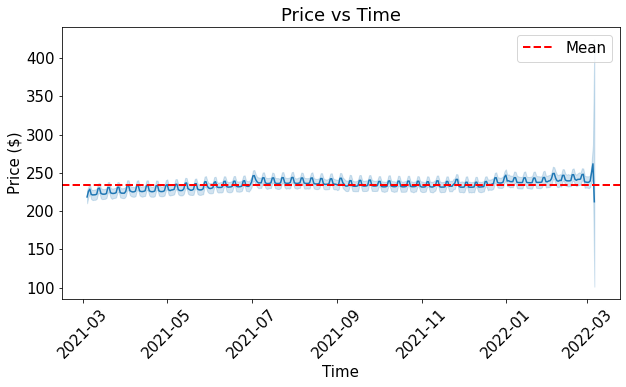

In [6]:
ax = sns.lineplot(x = "date", y = "price", markers = True, dashes = False, data = df_calendar)
plt.axhline(df_calendar['price'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
plt.xticks(rotation = 45)
plt.title('Price vs Time')
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.legend(loc='best')

- The average price is around 235.
- The price is steady over the year.

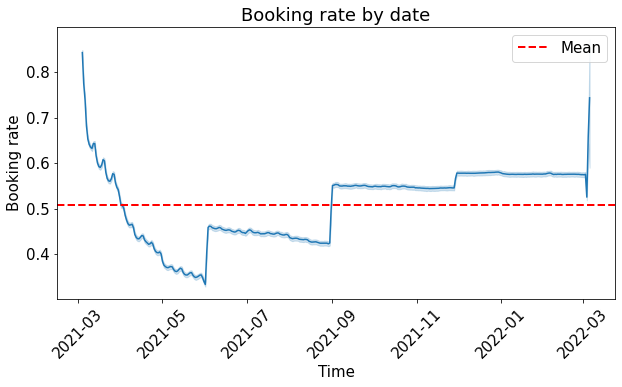

In [7]:
# Define available as 1 if 't'; o.w. 0.
df_calendar['available'] = df_calendar['available'].map({'t':0, 'f':1})

# Plot 
ax = sns.lineplot(x = "date", y = "available", markers = True, dashes = False, data = df_calendar)
plt.axhline(df_calendar['available'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
plt.xticks(rotation = 45)
plt.title('Booking rate by date')
plt.xlabel('Time')
plt.ylabel('Booking rate')
plt.legend(loc='best')

- Booking rate increase by June and September (Summer, etc.)

In [8]:
# Calculate daily revenue
df_calendar['revenue'] = df_calendar['price'] * df_calendar['available']

In [9]:
df_calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,revenue
0,109,2021-03-05,1,115.0,115.0,30.0,730.0,115.0
1,109,2021-03-06,1,115.0,115.0,30.0,730.0,115.0
2,109,2021-03-07,1,115.0,115.0,30.0,730.0,115.0
3,109,2021-03-08,1,115.0,115.0,30.0,730.0,115.0
4,109,2021-03-09,1,115.0,115.0,30.0,730.0,115.0


In [14]:
# Calculate financial overview of the booking.
occupancy = df_calendar.groupby('listing_id')['available', 'revenue'].mean()
occupancy.columns = ['occupancy_ratio', 'daily_revenue']

# Average daily revenue
print(np.mean(occupancy['daily_revenue']))

102.36359666035554


In [15]:
occupancy.head()

,occupancy_ratio,daily_revenue
listing_id,,
109,1.000000,120.391781
2708,0.164384,11.506849
2732,0.000000,0.000000
2864,1.000000,70.978082
5728,0.090411,4.095890


#### Listing cleaning
- Remove $ from price
- Remove unused columns

In [16]:
# Check data
df_listings.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,109,https://www.airbnb.com/rooms/109,20210303214021,2021-03-05,Amazing bright elegant condo park front *UPGRA...,"*** Unit upgraded with new bamboo flooring, br...",NaN,https://a0.muscache.com/pictures/4321499/1da98...,521,https://www.airbnb.com/users/show/521,Paolo,2008-06-27,"San Francisco, California, United States","Paolo Privitera, CEO Evensi\n\nPaolo, MIT MBA ...",within a day,100%,NaN,f,https://z0.muscache.cn/im/pictures/user/e704ac...,https://z0.muscache.cn/im/pictures/user/e704ac...,Culver City,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,NaN,Culver City,Other Cities,33.98209,-118.38494,Entire condominium,Entire home/apt,6,NaN,2 baths,2.0,3.0,"[""Dryer"", ""Pool"", ""First aid kit"", ""Kitchen"", ...",$115.00,30,730,30.0,30.0,730.0,730.0,30.0,730.0,NaN,t,0,0,0,0,2021-03-05,2,0,0,2011-08-15,2016-05-15,80.0,10.0,10.0,6.0,8.0,10.0,8.0,NaN,f,1,1,0,0,0.02
1,2708,https://www.airbnb.com/rooms/2708,20210303214021,2021-03-04,"Peace, Quiet, Cleanliness, Neatness, & Happiness",Run Runyon Canyon<br /><br />Beautifully Furni...,"Walk and run to Runyon Canyon, it is open!<br ...",https://a0.muscache.com/pictures/miso/Hosting-...,3008,https://www.airbnb.com/users/show/3008,Chas.,2008-09-16,"Los Angeles, California, United States",Writer.\r\nLiterary Manager.\r\nPhotographer.\...,within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/d17cf...,https://a0.muscache.com/im/pictures/user/d17cf...,Hollywood,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,t,"Los Angeles, California, United States",Hollywood,City of Los Angeles,34.09768,-118.34602,Private room in apartment,Private room,1,NaN,1.5 baths,1.0,1.0,"[""Stove"", ""Dryer"", ""Bed linens"", ""Luggage drop...",$70.00,30,366,30.0,30.0,1125.0,1125.0,30.0,1125.0,NaN,t,0,0,30,305,2021-03-04,29,6,1,2014-06-09,2021-02-21,97.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,t,2,0,2,0,0.35
2,2732,https://www.airbnb.com/rooms/2732,20210303214021,2021-03-04,Zen Life at the Beach,An oasis of tranquility awaits you.<br /><br /...,"This is the best part of Santa Monica. Quiet, ...",https://a0.muscache.com/pictures/1082974/0f74c...,3041,https://www.airbnb.com/users/show/3041,Yoga Priestess,2008-09-17,"Santa Monica, California, United States",I have been teaching yoga and meditation for 3...,within a few hours,80%,43%,f,https://a0.muscache.com/im/users/3041/profile_...,https://a0.muscache.com/im/users/3041/profile_...,Santa Monica,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Santa Monica, California, United States",Santa Monica,Other Cities,34.00475,-118.48127,Private room in apartment,Private room,1,NaN,1 private bath,1.0,1.0,"[""Heating"", ""Washer"", 

In [17]:
# Remove $ from price
df_listings["price"] = df_listings["price"].apply(lambda x: float(x.replace(',','')[1:]))

# Host is superhost, 1 if 't', 0 if 'f'
df_listings['host_is_superhost'] = df_listings['host_is_superhost'].map({'t':1, 'f':0})

# Get the number of bathrooms from the bathrooms_text
df_listings['bathrooms'] = df_listings["bathrooms_text"].str.extract("(\d*\.?\d+)", expand=True).astype(float)

# Change host_repsonse_rate and host_acceptance_rate from % to fraction
df_listings['host_response_rate'] = df_listings['host_response_rate'].str.replace("%", "")
df_listings['host_response_rate'] = df_listings['host_response_rate'].fillna(0).astype(float) / 100

df_listings['host_acceptance_rate'] = df_listings['host_acceptance_rate'].str.replace("%", "")
df_listings['host_acceptance_rate'] = df_listings['host_acceptance_rate'].fillna(0).astype(float) / 100

In [18]:
# Short term rental
df_listings = df_listings[df_listings["minimum_minimum_nights"] < 20]

In [19]:
# Keep useful columns
df_listings = df_listings[['id', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'longitude', 'latitude', 'room_type', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 'minimum_nights', 'maximum_nights', 'price', 'number_of_reviews', 'review_scores_rating','review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']]

In [20]:
# Combine datasets.
df = pd.merge(df_listings, occupancy, how='left', left_on='id', right_on='listing_id')
df.head()

,id,host_response_rate,host_acceptance_rate,host_is_superhost,neighbourhood_cleansed,neighbourhood_group_cleansed,longitude,latitude,room_type,accommodates,bedrooms,beds,bathrooms,minimum_nights,maximum_nights,price,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,occupancy_ratio,daily_revenue
0,2732,0.8,0.43,0.0,Santa Monica,Other Cities,-118.48127,34.00475,Private room,1,1.0,1.0,1.0,1,180,155.0,21,94.0,9.0,9.0,9.0,9.0,10.0,9.0,0.000000,0.000000
1,7874,1.0,0.86,0.0,Bellflower,Other Cities,-118.11509,33.87610,Private room,2,1.0,1.0,1.0,1,730,55.0,12,98.0,10.0,10.0,10.0,10.0,10.0,10.0,1.000000,55.000000
2,7992,1.0,0.78,1.0,Atwater Village,City of Los Angeles,-118.26090,34.11543,Entire home/apt,4,1.0,2.0,1.0,1,1125,89.0,241,99.0,10.0,10.0,10.0,10.0,10.0,10.0,0.786301,70.712329
3,9140,0.0,0.00,0.0,Long Beach,Other Cities,-118.18893,33.77206,Private room,2,1.0,1.0,1.5,2,1125,80.0,393,95.0,10.0,9.0,9.0,10.0,10.0,10.0,1.000000,80.906849
4,9545,1.0,0.99,1.0,Redondo Beach,Other Cities,-118.38569,33.83823,Private room,1,1.0,1.0,1.5,1,1125,70.0,137,97.0,10.0,10.0,10.0,10.0,10.0,10.0,0.073973,5.178082


In [21]:
# Checking missing value
df.isnull().sum()

id                                 0
host_response_rate                 0
host_acceptance_rate               0
host_is_superhost                 11
neighbourhood_cleansed             0
neighbourhood_group_cleansed       0
longitude                          0
latitude                           0
room_type                          0
accommodates                       0
bedrooms                        1505
beds                             221
bathrooms                         61
minimum_nights                     0
maximum_nights                     0
price                              0
number_of_reviews                  0
review_scores_rating            2733
review_scores_accuracy          2883
review_scores_cleanliness       2883
review_scores_checkin           2887
review_scores_communication     2884
review_scores_location          2888
review_scores_value             2889
occupancy_ratio                    0
daily_revenue                      0
dtype: int64

In [22]:
# Remove NA from beds and bedrooms for now, could change to mean or median in the future.
df = df.dropna()

<Figure size 720x1440 with 0 Axes>

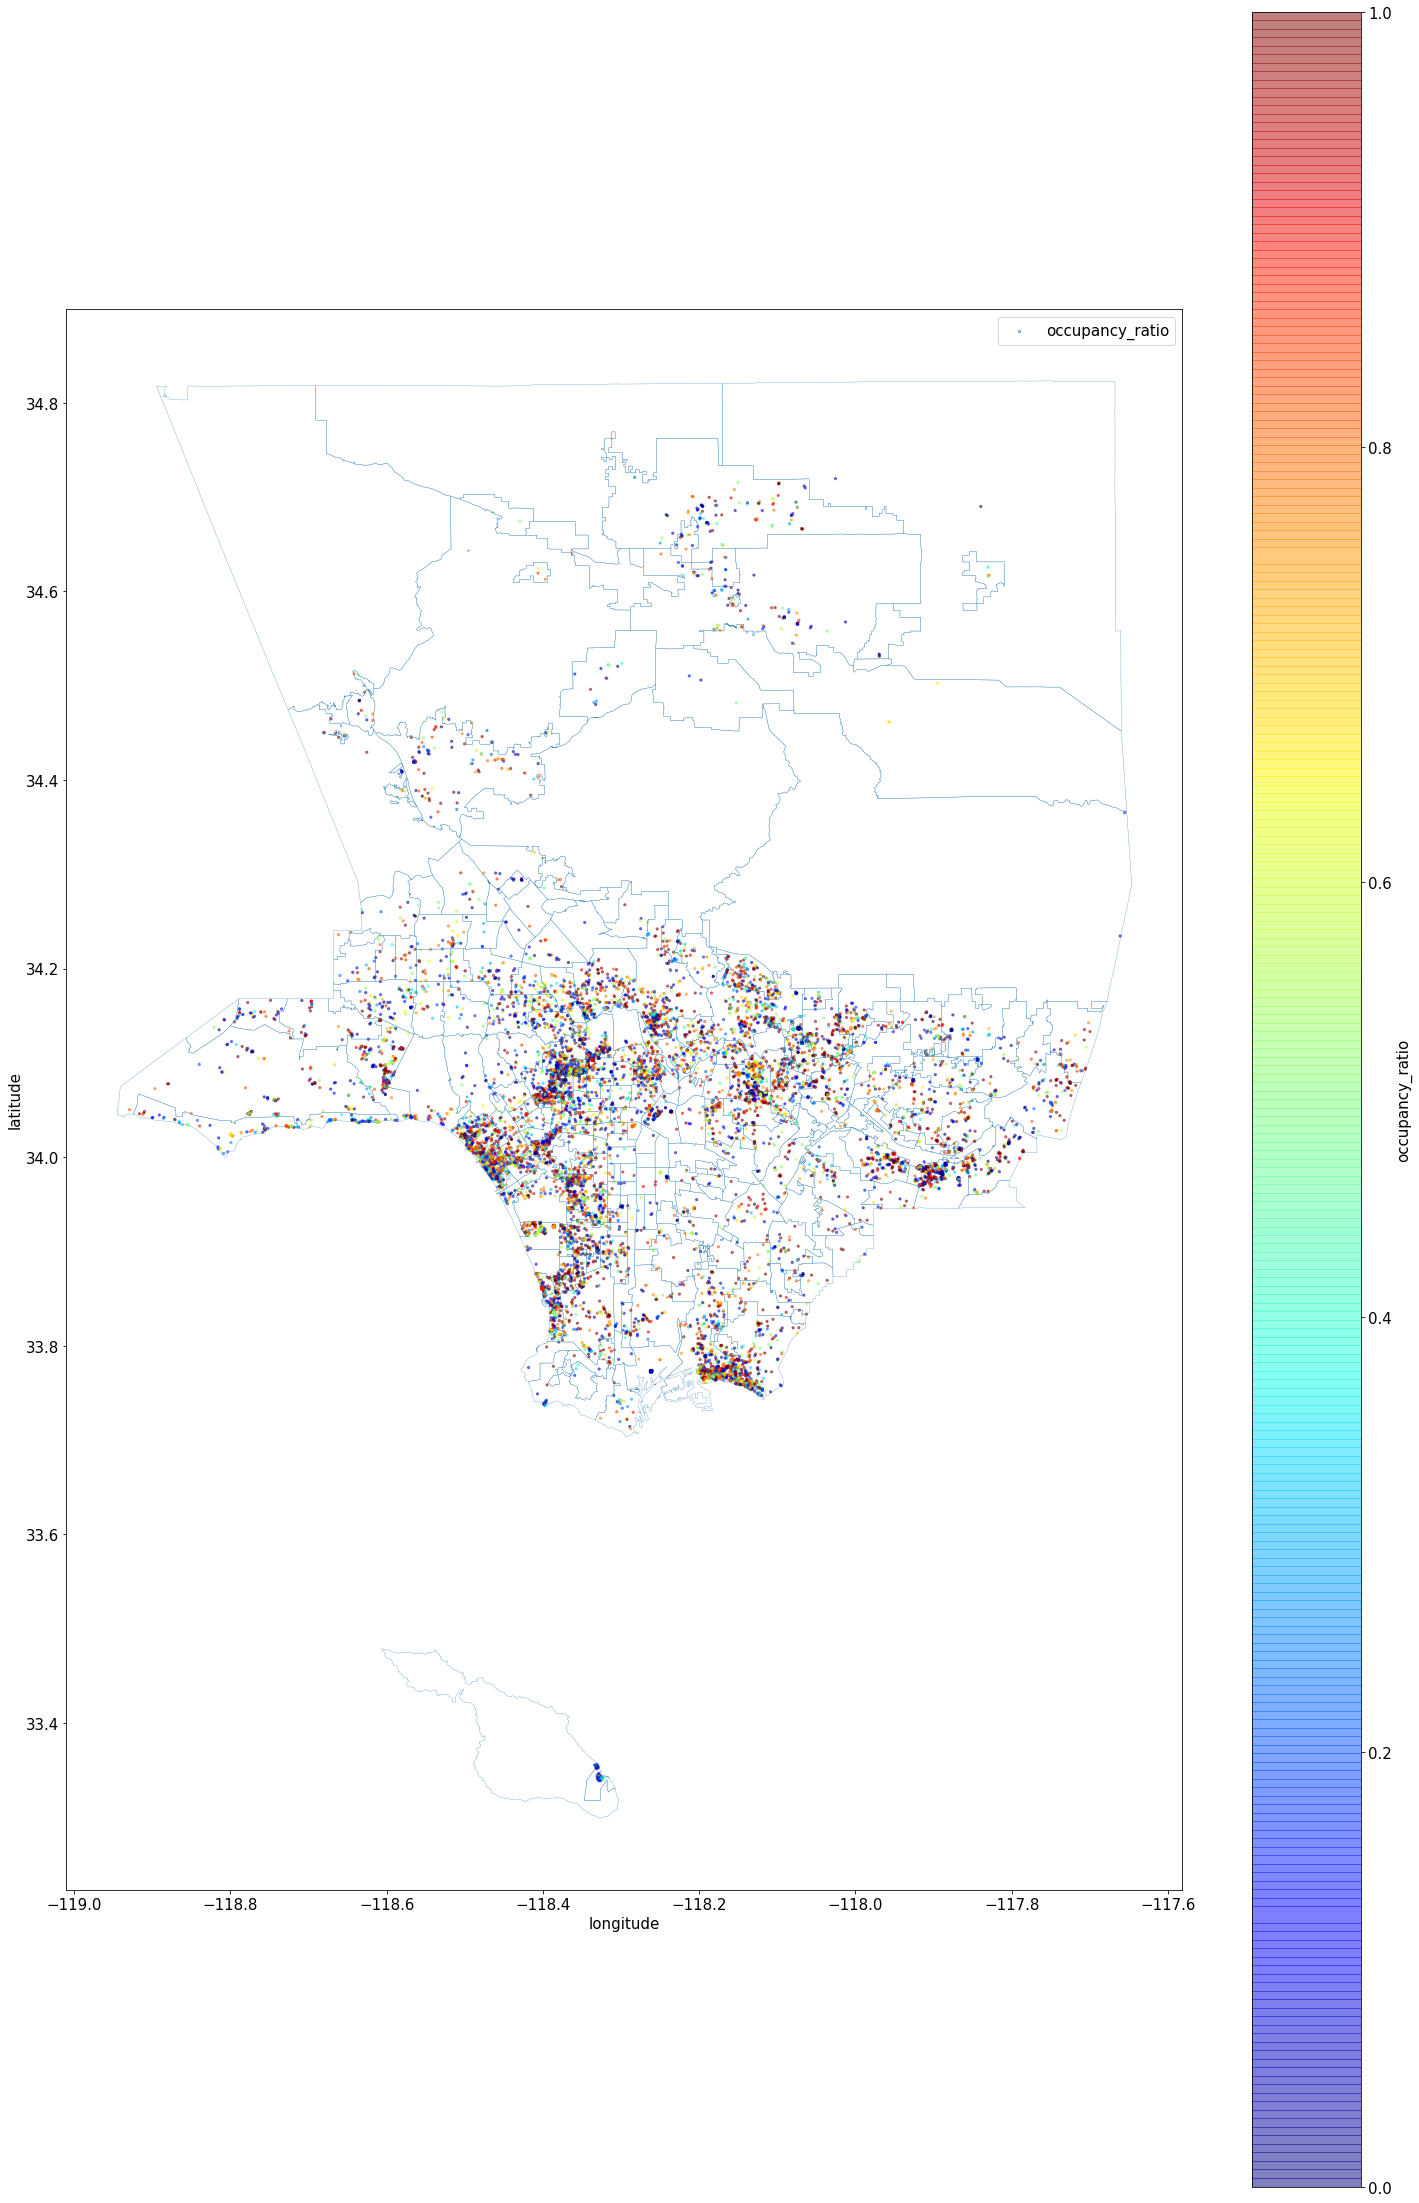

In [24]:
# Plot occupancy_ratio rate of Los Angeles
la_map = gpd.read_file('Data/neighbourhoods.geojson')

plt.figure(figsize=(10,20))
ax = la_map.boundary.plot(linewidth = 0.25)
ax.set_facecolor("white")
df.plot(kind='scatter', x='longitude', y='latitude', label='occupancy_ratio', c='occupancy_ratio',
                  cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.5, s=  5, figsize=(25,40), ax=ax)

plt.legend()
plt.show()

In [25]:
# Remove outliers
def outliers(df, column, num_dev=4):
    q25, q75 = df[column].quantile(q=[0.25, 0.75])
    iqr = q75 - q25
    max_n = q75 + num_dev * iqr
    # identify the points
    outlier_mask = [True if x > max_n else False for x in df[column]]
    print('{} outliers found out of {} data points, {}% of the data. {} is the max'.format(
        sum(outlier_mask), len(df[column]),
        100 * (sum(outlier_mask) / len(df[column])),max_n))
    return outlier_mask

df['outliers'] = outliers(df, 'bedrooms')
df = df[df['outliers'] == False]

df['outliers'] = outliers(df, 'beds', num_dev = 5)
df = df[df['outliers'] == False]

df['outliers'] = outliers(df, 'bathrooms')
df = df[df['outliers'] == False]

df.drop(labels='outliers', inplace=True, axis=1)

29 outliers found out of 10620 data points, 0.27306967984934083% of the data. 6.0 is the max
4 outliers found out of 10591 data points, 0.037767916155226136% of the data. 13.0 is the max
37 outliers found out of 10587 data points, 0.3494852177198451% of the data. 6.0 is the max


<AxesSubplot:>

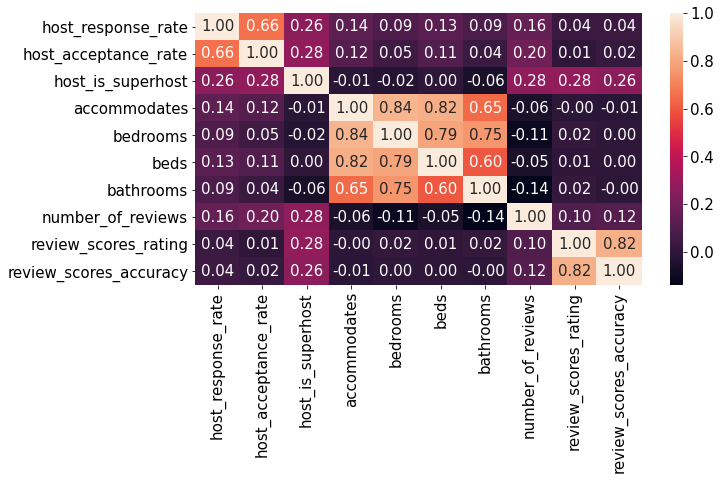

In [26]:
# Correlations
corr_score = df[['host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 'number_of_reviews', 'review_scores_rating','review_scores_accuracy']].corr()
sns.heatmap(corr_score, annot=True, fmt=".2f")

## Modeling

#### Occupancy rate

In [27]:
# Get feature
X = df[['host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'neighbourhood_group_cleansed', 'room_type', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating','review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']]
X.dtypes

host_response_rate              float64
host_acceptance_rate            float64
host_is_superhost               float64
neighbourhood_group_cleansed     object
room_type                        object
accommodates                      int64
bedrooms                        float64
beds                            float64
bathrooms                       float64
minimum_nights                    int64
maximum_nights                    int64
number_of_reviews                 int64
review_scores_rating            float64
review_scores_accuracy          float64
review_scores_cleanliness       float64
review_scores_checkin           float64
review_scores_communication     float64
review_scores_location          float64
review_scores_value             float64
dtype: object

In [28]:
y = df['occupancy_ratio']

In [29]:
# One hot encoding
def OneHotEncoding(df, enc, categories):  
  transformed = pd.DataFrame(enc.transform(df[categories]).toarray(), columns=enc.get_feature_names(categories))
  return pd.concat([df.reset_index(drop=True), transformed], axis=1).drop(categories, axis=1)

categories = ['neighbourhood_group_cleansed', 'room_type']
enc_ohe = OneHotEncoder()
enc_ohe.fit(X[categories])

X = OneHotEncoding(X, enc_ohe, categories)

In [30]:
X.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,accommodates,bedrooms,beds,bathrooms,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,neighbourhood_group_cleansed_City of Los Angeles,neighbourhood_group_cleansed_Other Cities,neighbourhood_group_cleansed_Unincorporated Areas,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,0.8,0.43,0.0,1,1.0,1.0,1.0,1,180,21,94.0,9.0,9.0,9.0,9.0,10.0,9.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.86,0.0,2,1.0,1.0,1.0,1,730,12,98.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.78,1.0,4,1.0,2.0,1.0,1,1125,241,99.0,10.0,10.0,10.0,10.0,10.0,10.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.00,0.0,2,1.0,1.0,1.5,2,1125,393,95.0,10.0,9.0,9.0,10.0,10.0,10.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.99,1.0,1,1.0,1.0,1.5,1,1125,137,97.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [31]:
# Split dataset (Reserve 25% for testing)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=1)

print('training data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' features')
print('test data has ' + str(X_test.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' features')

training data has 7912 observation with 24 features
test data has 2638 observation with 24 features


##### Model development

##### Linear Regression

In [32]:
# Linear Regression
LR = LinearRegression()
LR.fit(X_train, y_train)

LinearRegression()

##### Lasso

In [33]:
from sklearn.linear_model import Lasso
# Grid search to find best lambda
from sklearn.model_selection import GridSearchCV
from numpy import arange

# define penalty parameter
grid = {'alpha':arange(0,1,100)}

Grid_Lasso = GridSearchCV(Lasso(),grid, scoring='neg_mean_absolute_error', cv=10)
results_lasso=Grid_Lasso.fit(X_train,y_train)
# summarize best MSE and best penalty parameter
print('MAE: %.3f' % -results_lasso.best_score_)
print('Config: %s' % results_lasso.best_params_)

MAE: 0.297
Config: {'alpha': 0}


##### Ridge

In [34]:
# Grid search to find best lambda
from sklearn.model_selection import GridSearchCV

# define penalty parameter
grid = {'alpha':arange(0,1,0.01)}

Grid_Ridge = GridSearchCV(Ridge(),grid, scoring='neg_mean_absolute_error', cv=10)
results_Ridge=Grid_Ridge.fit(X_train,y_train)
# summarize best MSE and best penalty parameter
print('MAE: %.3f' % -results_Ridge.best_score_)
print('Config: %s' % results_Ridge.best_params_)

MAE: 0.297
Config: {'alpha': 0.01}


In [35]:
ridge_penalty = Ridge(alpha=0.01)
ridge_penalty.fit(X_train,y_train)

Ridge(alpha=0.01)

##### Random Forest

In [36]:
#random forest regressor
from sklearn.ensemble import RandomForestRegressor
regress_RF = RandomForestRegressor()
regress_RF.fit(X_train, y_train)

RandomForestRegressor()

##### KNN

In [37]:
#KNN regressor
from sklearn.neighbors import KNeighborsRegressor
regress_KNN = KNeighborsRegressor()
regress_KNN.fit(X_train, y_train)

KNeighborsRegressor()

##### Support Vector Regression

In [38]:
from sklearn import svm
regress_SVM = svm.SVR()
regress_SVM.fit(X_train,y_train)

SVR()

##### Bayesian Ridge

In [39]:
from sklearn.linear_model import BayesianRidge
regress_Baye = BayesianRidge()
regress_Baye.fit(X_train,y_train)

BayesianRidge()

##### Model Evaluation

$R^2$

In [40]:
# Use 10-fold Cross Validation to get the accuracy for different models
model_names = ['Linear Regression','Ridge Regression','Random Forest Regressor','K-nearest Neignbor Regressor','Support Vector Regression','Bayesian Ridge']
model_list = [LR,ridge_penalty,regress_RF,regress_KNN,regress_SVM,regress_Baye]
count = 0

for regressor in model_list:
    cv_score = model_selection.cross_val_score(regressor, X_train, y_train, cv=10)
    print(cv_score)
    print('Model R-square of ' + model_names[count] + ' is ' + str(cv_score.mean()))
    print(" ")
    count += 1

[0.17130442 0.12669045 0.10973001 0.20841973 0.20033752 0.21421476
 0.14818067 0.13356722 0.1405442  0.14279625]
Model R-square of Linear Regression is 0.15957852321234373
 
[0.17130455 0.12669102 0.10972991 0.20841977 0.20033705 0.21421475
 0.1481808  0.1335674  0.14054447 0.14279655]
Model R-square of Ridge Regression is 0.15957862666774916
 
[0.23921766 0.19440758 0.20060453 0.26983992 0.27174682 0.26530296
 0.24652942 0.16045304 0.21986721 0.22657509]
Model R-square of Random Forest Regressor is 0.2294544221805248
 
[-0.00463499 -0.06291556 -0.07287849  0.02111257 -0.10582265 -0.03081563
 -0.02266873 -0.05944369 -0.00531483 -0.05503186]
Model R-square of K-nearest Neignbor Regressor is -0.039841386740825435
 
[ 0.04435585  0.02433996 -0.01230392  0.03723764  0.00043555  0.06122657
  0.02168318 -0.00476384  0.02485762  0.00461332]
Model R-square of Support Vector Regression is 0.02016819262661501
 
[0.17143329 0.12778089 0.10962433 0.20836913 0.19908894 0.2138117
 0.14838268 0.13390

Mean Squared Error

In [41]:
# Use 10-fold Cross Validation to get the accuracy for different models
model_names = ['Linear Regression','Ridge Regression','Random Forest Regressor','K-nearest Neignbor Regressor','Support Vector Regression','Bayesian Ridge']
model_list = [LR,ridge_penalty,regress_RF,regress_KNN,regress_SVM,regress_Baye]
count = 0

for regressor in model_list:
    cv_score = model_selection.cross_val_score(regressor, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
    print(cv_score)
    print('Model mean squared error of ' + model_names[count] + ' is ' + str(-cv_score.mean()))
    print(' ')
    count += 1

[-0.11051209 -0.11687024 -0.12577799 -0.10545989 -0.11065546 -0.11232633
 -0.11963404 -0.1150301  -0.1190969  -0.11715669]
Model mean squared error of Linear Regression is 0.11525197300634367
 
[-0.11051207 -0.11687017 -0.125778   -0.10545988 -0.11065553 -0.11232633
 -0.11963402 -0.11503008 -0.11909686 -0.11715665]
Model mean squared error of Ridge Regression is 0.11525195918850513
 
[-0.10004197 -0.10892293 -0.11433937 -0.09648784 -0.1003402  -0.10395138
 -0.10713787 -0.1099214  -0.1087341  -0.10535514]
Model mean squared error of Random Forest Regressor is 0.10552321963266229
 
[-0.13397478 -0.14224418 -0.15157705 -0.13041427 -0.15302121 -0.14735291
 -0.14362903 -0.14065479 -0.13930894 -0.14419448]
Model mean squared error of K-nearest Neignbor Regressor is 0.142637162164275
 
[-0.12744153 -0.13056725 -0.14301903 -0.12826597 -0.13831744 -0.13419567
 -0.13740002 -0.13339533 -0.13512787 -0.13604258]
Model mean squared error of Support Vector Regression is 0.1343772684901784
 
[-0.11049

Best model: RF regressor  
Worest model: KNN regressor (too many features)

##### Feature Importance of RF

In [42]:
importances = regress_RF.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for ind in range(X.shape[1]):
  print ("{0} : {1}".format(X.columns[indices[ind]],round(importances[indices[ind]], 4)))

Feature importance ranking by Random Forest Model:
host_response_rate : 0.1704
number_of_reviews : 0.1567
host_acceptance_rate : 0.1089
maximum_nights : 0.0947
review_scores_rating : 0.0685
minimum_nights : 0.0665
accommodates : 0.0548
beds : 0.0398
bathrooms : 0.0371
review_scores_cleanliness : 0.0208
review_scores_value : 0.0203
bedrooms : 0.0188
host_is_superhost : 0.0183
review_scores_location : 0.0168
neighbourhood_group_cleansed_Other Cities : 0.0159
neighbourhood_group_cleansed_City of Los Angeles : 0.0148
neighbourhood_group_cleansed_Unincorporated Areas : 0.0134
review_scores_accuracy : 0.0122
review_scores_checkin : 0.0118
review_scores_communication : 0.0112
room_type_Entire home/apt : 0.0106
room_type_Private room : 0.0096
room_type_Hotel room : 0.0046
room_type_Shared room : 0.0036
